In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

In [106]:
#log-transform
def log_transform(X, columns):
    X = X.copy()
    for col in columns:
        X[col] = np.log(X[col])
    return X

In [107]:
def update_column_names(df):
    df = df.rename(columns={
        'Temperature': 'Temperatura',
        'Humidity': 'Umidade',
        'Wind Speed': 'Velocidade_do_Vento',
        'Cloud Cover': 'Cobertura_de_Nuvens',
        'Pressure': 'Pressao',
        'Location': 'Localizacao',
        'Rain Tomorrow': 'Chovera_Amanha',
        'Precipitation': 'Precipitacao',
        'Date':'Data',
    })
    return df

In [108]:
def get_season(date):
        month = date.month
        day = date.day
        if ((month >= 3 and day >= 20) and (month <= 6 and day < 21)):
                return 'Primavera'
        elif (month >= 6 and ( month <= 9 and day < 23)):
                return 'Verão'
        elif (month >= 9 and (month <= 12 and day < 21)):
                return 'Outono'
        else:
                return 'Inverno'

In [109]:
cidade_para_estado = {
    'Los Angeles': 'California', 
    'Chicago': 'Illinois', 
    'Houston': 'Texas',
    'Phoenix': 'Arizona',
    'Philadelphia': 'Pennsylvania',
    'San Antonio': 'Texas', 
    'San Diego': 'California',
    'Dallas': 'Texas',
    'San Jose': 'California', 
    'Austin': 'Texas', 
    'Jacksonville': 'Florida', 
    'Fort Worth': 'Texas',
    'Columbus': 'Ohio', 
    'Indianapolis': 'Indiana', 
    'Charlotte': 'North Carolina', 
    'San Francisco': 'California',
    'Seattle': 'Washington', 
    'Denver': 'Colorado', 
    'New York': 'New York', 
    'Washington D.C.': 
    'District of Columbia'
}
estado_para_regiao = {
    'California': 'Oeste',
    'Illinois': 'Meio-Oeste',
    'Texas': 'Sul',
    'Arizona': 'Oeste',
    'Pennsylvania': 'Nordeste',
    'Florida': 'Sul',
    'Ohio': 'Meio-Oeste',
    'Indiana': 'Meio-Oeste',
    'North Carolina': 'Sul',
    'Washington': 'Oeste',
    'Colorado': 'Oeste',
    'New York': 'Nordeste',
    'District of Columbia': 'Sul'
}
def cidade_para_regiao(cidade: pd.Series) -> str:
    cidade = cidade.title()
    estado = cidade_para_estado.get(cidade)
    return estado_para_regiao.get(estado) if estado else None

In [110]:
numeric_features_pt = ['Temperatura', 'Umidade', 'Velocidade_do_Vento', 'Cobertura_de_Nuvens', 'Pressao']
categorical_features_pt = ['Estacao', 'Regiao']

def pre_processar_df(df, numeric_columns):
    # Transformando os dados numéricos para o log
    df = log_transform(df, numeric_columns)

    # Cria a coluna Estacao
    df['Data'] = pd.to_datetime(df['Data'])
    
    df["Estacao"] = df["Data"].apply(get_season)
    
    # Cria a coluna Regiao
    df['Regiao'] = df['Localizacao'].apply(cidade_para_regiao)

    # Remove colunas originais que não serão mais usadas
    df = df.drop(['Data', 'Localizacao'], axis=1)
    return df

# Para usar no pipeline:
preprocess_func = FunctionTransformer(pre_processar_df, kw_args={'numeric_columns': numeric_features_pt}, validate=False)


preprocess_before_transforms_pipeline = Pipeline([
    ('preprocess_func', preprocess_func)
])

numeric_transformer = Pipeline([
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(sparse_output=False))
])

# Preprocessamento
# Cria o pré-processador

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features_pt),
    ('cat', categorical_transformer, categorical_features_pt)
], remainder='passthrough')

preprocessor_without_scaling = ColumnTransformer([
    ('cat', categorical_transformer, categorical_features_pt)
], remainder='passthrough')


# Criando as pipelines
pipeline_sem_scaling = Pipeline([
    ('preprocess_func', preprocess_func),
    ('preprocessor', preprocessor_without_scaling),
    ('classifier', LogisticRegression())
])

pipeline = Pipeline([
    ('preprocess_func', preprocess_func),
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

search_spaces_logistic = {
    'classifier__C': Real(1e-3, 1.0, prior='log-uniform'),
    'classifier__max_iter': Integer(100, 1000),
}

search_spaces_random_forest = {
    'classifier__n_estimators': Integer(50, 100),
    'classifier__max_depth': Integer(2, 10),
    'classifier__bootstrap': Categorical([True, False])
}

search_spaces_decision_tree = {
    'classifier__criterion': Categorical(['gini', 'entropy']),
    'classifier__splitter': Categorical(['best', 'random'])
}

search_spaces_knn = {
    'classifier__n_neighbors': Integer(1, 10),
    'classifier__weights': Categorical(['uniform', 'distance']),
    'classifier__algorithm': Categorical(['auto', 'ball_tree', 'kd_tree'])
}

search_spaces_sgd = {
    'classifier__loss': Categorical(['hinge', 'log_loss', 'squared_hinge', 'modified_huber']),
    'classifier__penalty': Categorical(['l2', 'l1', 'elasticnet']),
    'classifier__alpha': Real(1e-5, 1e-1, prior='log-uniform')
}

In [111]:
# Carregar dados para pipeline e vizualiuzação do durante o notebook
df_to_pipeline_use = pd.read_csv('usa_rain_prediction_dataset_2024_2025.csv')  # Substitua com o caminho correto
df = df_to_pipeline_use.copy()
print(df.head())

# Atualiza os nomes das colunas para português para facilitar a leitura
# e a visualização dos dados
df = update_column_names(df)
df_to_pipeline_use = update_column_names(df_to_pipeline_use)
print(df.head())

         Date  Location  Temperature   Humidity  Wind Speed  Precipitation  \
0  2024-01-01  New York    87.524795  75.655455   28.379506       0.000000   
1  2024-01-02  New York    83.259325  28.712617   12.436433       0.526995   
2  2024-01-03  New York    80.943050  64.740043   14.184831       0.916884   
3  2024-01-04  New York    78.097552  59.738984   19.444029       0.094134   
4  2024-01-05  New York    37.059963  34.766784    3.689661       1.361272   

   Cloud Cover     Pressure  Rain Tomorrow  
0    69.617966  1026.030278              0  
1    41.606048   995.962065              0  
2    77.364763   980.796739              1  
3    52.541196   979.012163              0  
4    85.584000  1031.790859              0  
         Data Localizacao  Temperatura    Umidade  Velocidade_do_Vento  \
0  2024-01-01    New York    87.524795  75.655455            28.379506   
1  2024-01-02    New York    83.259325  28.712617            12.436433   
2  2024-01-03    New York    80.943050 

In [112]:
# Faz o log das colunas numéricas para evitar problemas de assimetria
# e melhorar a performance do modelo
log_transform_columns = numeric_features_pt.copy()
df = log_transform(df, log_transform_columns)

In [113]:
# Atualiza os nomes das colunas para português
df['Data'] = pd.to_datetime(df['Data'])

df["Estacao"] = df["Data"].apply(get_season)

# Cria a coluna Regiao e faz o OneHotEncoding para a coluna Estacao
# Não usado durante o pipeline, mas necessário para visualização

encoder = OneHotEncoder(sparse_output=False)
estacao_encoded = encoder.fit_transform(df[["Estacao"]])
estacao_df = pd.DataFrame(estacao_encoded, columns=encoder.get_feature_names_out(["Estacao"]))
df = pd.concat([df, estacao_df], axis=1)

print(df.head())

        Data Localizacao  Temperatura   Umidade  Velocidade_do_Vento  \
0 2024-01-01    New York     4.471922  4.326190             3.345667   
1 2024-01-02    New York     4.421960  3.357337             2.520630   
2 2024-01-03    New York     4.393746  4.170380             2.652173   
3 2024-01-04    New York     4.357959  4.089985             2.967540   
4 2024-01-05    New York     3.612537  3.548662             1.305534   

   Precipitacao  Cobertura_de_Nuvens   Pressao  Chovera_Amanha  Estacao  \
0      0.000000             4.243023  6.933453               0  Inverno   
1      0.526995             3.728246  6.903709               0  Inverno   
2      0.916884             4.348531  6.888365               1  Inverno   
3      0.094134             3.961598  6.886544               0  Inverno   
4      1.361272             4.449498  6.939051               0  Inverno   

   Estacao_Inverno  Estacao_Outono  Estacao_Primavera  Estacao_Verão  
0              1.0             0.0           

In [114]:
# Mapeamento completo de cidades para estados
cidade_para_estado = {
    'Los Angeles': 'California',
    'Chicago': 'Illinois',
    'Houston': 'Texas',
    'Phoenix': 'Arizona',
    'Philadelphia': 'Pennsylvania',
    'San Antonio': 'Texas',
    'San Diego': 'California',
    'Dallas': 'Texas',
    'San Jose': 'California',
    'Austin': 'Texas',
    'Jacksonville': 'Florida',
    'Fort Worth': 'Texas',
    'Columbus': 'Ohio',
    'Indianapolis': 'Indiana',
    'Charlotte': 'North Carolina',
    'San Francisco': 'California',
    'Seattle': 'Washington',
    'Denver': 'Colorado',
    'New York': 'New York',
    'Washington D.C.': 'District of Columbia'
}

estado_para_regiao = {
    'California': 'Oeste',
    'Illinois': 'Meio-Oeste',
    'Texas': 'Sul',
    'Arizona': 'Oeste',
    'Pennsylvania': 'Nordeste',
    'Florida': 'Sul',
    'Ohio': 'Meio-Oeste',
    'Indiana': 'Meio-Oeste',
    'North Carolina': 'Sul',
    'Washington': 'Oeste',
    'Colorado': 'Oeste',
    'New York': 'Nordeste',
    'District of Columbia': 'Sul'
}

# Cria a coluna Regiao para cada cidade e verifica se todas as cidades foram mapeadas
df['Regiao'] = df['Localizacao'].apply(cidade_para_regiao)

cidades_nao_mapeadas = df[df['Regiao'].isna()]['Localizacao'].unique()
if len(cidades_nao_mapeadas) > 0:
    print(f"\nCidades não mapeadas: {cidades_nao_mapeadas}")
else:
    print("\nTodas as cidades foram mapeadas com sucesso!")

# Faz o OneHotEncoding para a coluna Regiao
# Não usado durante o pipeline, mas necessário para visualização
encoder = OneHotEncoder(sparse_output=False)
region_encoded = encoder.fit_transform(df[['Regiao']])
region_df = pd.DataFrame(region_encoded, columns=encoder.get_feature_names_out(['Regiao']))
df = pd.concat([df, region_df], axis=1)

print(f"Regiao Nan sum: {df['Regiao'].isna().sum()}")
df.head(n=20)

# Dropa as colunas que não serão mais usadas
df = df.drop(['Data', 'Localizacao', 'Estacao', 'Regiao'], axis=1)
df.head()



Todas as cidades foram mapeadas com sucesso!
Regiao Nan sum: 0


,Temperatura,Umidade,Velocidade_do_Vento,Precipitacao,Cobertura_de_Nuvens,Pressao,Chovera_Amanha,Estacao_Inverno,Estacao_Outono,Estacao_Primavera,Estacao_Verão,Regiao_Meio-Oeste,Regiao_Nordeste,Regiao_Oeste,Regiao_Sul
0,4.471922,4.326190,3.345667,0.000000,4.243023,6.933453,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,4.421960,3.357337,2.520630,0.526995,3.728246,6.903709,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,4.393746,4.170380,2.652173,0.916884,4.348531,6.888365,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,4.357959,4.089985,2.967540,0.094134,3.961598,6.886544,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,3.612537,3.548662,1.305534,1.361272,4.449498,6.939051,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [115]:

# Separa os dados em X e y e divide em treino e teste

X = df.drop('Chovera_Amanha', axis=1)
y = df['Chovera_Amanha']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)
print(f"X_train shape: {X.shape}")
print(X_train.head())


X_train shape: (73100, 14)
       Temperatura   Umidade  Velocidade_do_Vento  Precipitacao  \
64233     4.039951  3.565208            -0.354594      0.111800   
23267     3.664839  3.386565             3.349362      0.324512   
31891     4.294233  4.523675             2.568137      0.340564   
54290     3.461568  4.150026             2.503818      0.000000   
2659      4.243323  4.192802             3.297341      0.546803   

       Cobertura_de_Nuvens   Pressao  Estacao_Inverno  Estacao_Outono  \
64233             3.852428  6.881600              1.0             0.0   
23267             4.190044  6.891839              1.0             0.0   
31891             3.665360  6.916251              1.0             0.0   
54290             4.409801  6.893105              0.0             0.0   
2659              3.913493  6.900154              1.0             0.0   

       Estacao_Primavera  Estacao_Verão  Regiao_Meio-Oeste  Regiao_Nordeste  \
64233                0.0            0.0             

Temperatura            0.112389
Umidade                0.190539
Velocidade_do_Vento    1.011426
Precipitacao           0.225466
Cobertura_de_Nuvens    0.345573
Pressao                0.000404
Chovera_Amanha         0.171832
Estacao_Inverno        0.242457
Estacao_Outono         0.137212
Estacao_Primavera      0.010824
Estacao_Verão          0.181374
Regiao_Meio-Oeste      0.127502
Regiao_Nordeste        0.090001
Regiao_Oeste           0.227503
Regiao_Sul             0.240003
dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Temperatura          73100 non-null  float64
 1   Umidade              73100 non-null  float64
 2   Velocidade_do_Vento  73100 non-null  float64
 3   Precipitacao         73100 non-null  float64
 4   Cobertura_de_Nuvens  73100 non-null  float64
 5   Pressao              73100 non-null  floa

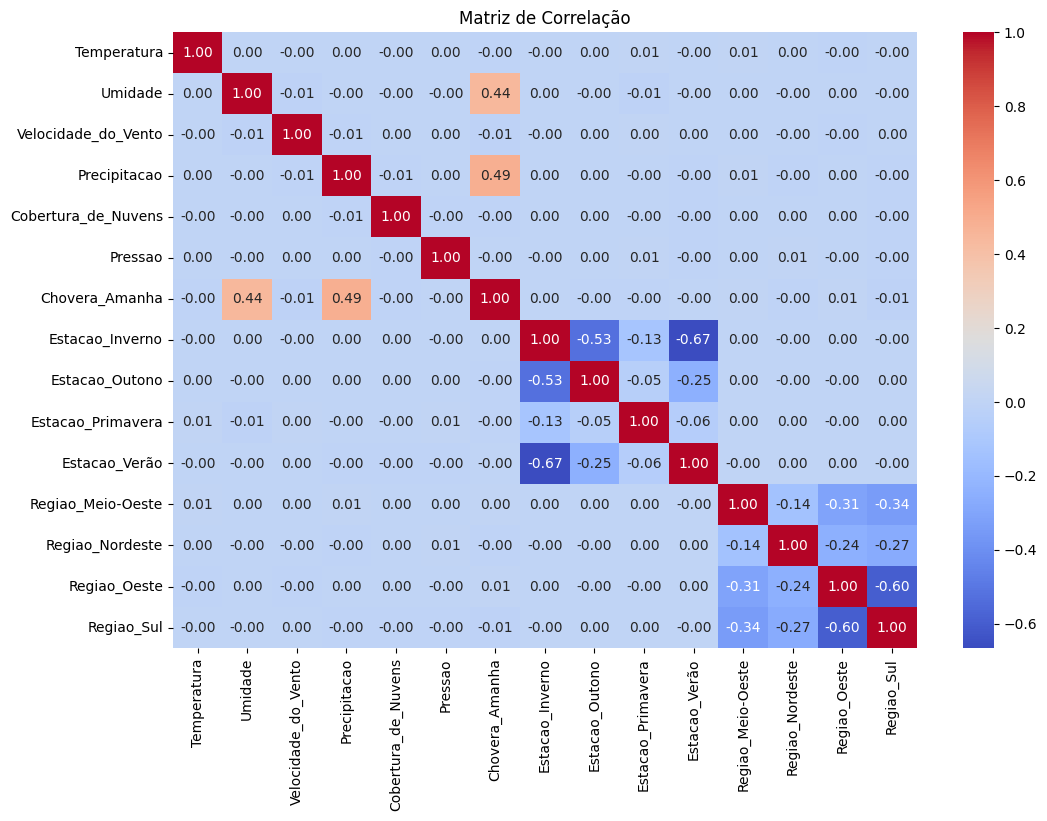

In [116]:
print(df.var(numeric_only=True))
print(df.info())
print(df.describe())
print(df.isnull().sum())

plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size":10})
plt.title('Matriz de Correlação')
plt.show()


In [ ]:
def avaliar_modelos(X_train, X_test, y_train, y_test, scaled=False):
    if scaled:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
    modelos = {
        'Logistic Regression': LogisticRegression(max_iter=1000, C=1.0),
        'Decision Tree': DecisionTreeClassifier(max_depth=5),
        'Random Forest': RandomForestClassifier()
    }

    resultados = []

    for nome, modelo in modelos.items():
        modelo.fit(X_train, y_train)
        y_pred_train = modelo.predict(X_train)
        y_pred_test = modelo.predict(X_test)

        resultados.append({
            'Modelo': nome + (' (Escalado)' if scaled else ''),
            'Accuracy Train': accuracy_score(y_train, y_pred_train),
            'Accuracy Test': accuracy_score(y_test, y_pred_test),
            'Precision Train': precision_score(y_train, y_pred_train),
            'Precision Test': precision_score(y_test, y_pred_test),
            'Recall Train': recall_score(y_train, y_pred_train),
            'Recall Test': recall_score(y_test, y_pred_test),
            'F1 Score Train': f1_score(y_train, y_pred_train),
            'F1 Score Test': f1_score(y_test, y_pred_test),
            'Melhores Hiperparâmetros': None,
            'y_pred_train': y_pred_train,
            'y_pred_test': y_pred_test,
            'Melhor Modelo': None,
        })

    return resultados


In [ ]:
def avaliar_modelos_pipeline(X_train, X_test, y_train, y_test, search_spaces, modelo = LogisticRegression, scaled=False):
    pipeline_a_ser_usada = pipeline_sem_scaling if not scaled else pipeline
    
    pipeline_a_ser_usada.set_params(classifier=modelo)
    bayes_search = BayesSearchCV(
        estimator=pipeline_a_ser_usada,
        search_spaces=search_spaces,
        n_iter=10,  # Ajuste conforme o tempo disponível
        cv=10,
        n_jobs=-1,
        verbose=2,
        random_state=42
    )
    print(f"Treinando com a Pipeline: {pipeline_a_ser_usada}")
    # Treina o BayesSearchCV

    # Pega o melhor pipeline encontrado
    melhor_pipeline = bayes_search.best_estimator_
    
    # Faz predições com o melhor pipeline
    y_pred_train = cross_val_predict(melhor_pipeline, X_train, y_train, cv=10, n_jobs=-1)
    
    melhor_pipeline.fit(X_train, y_train)
    y_pred_test = melhor_pipeline.predict(X_test)

    return {
        'Modelo': type(melhor_pipeline.named_steps['classifier']).__name__ + (' (Escalado)' if scaled else ''),
        'Melhor Modelo' : melhor_pipeline,
        'Accuracy Train': accuracy_score(y_train, y_pred_train),
        'Accuracy Test': accuracy_score(y_test, y_pred_test),
        'Precision Train': precision_score(y_train, y_pred_train),
        'Precision Test': precision_score(y_test, y_pred_test),
        'Recall Train': recall_score(y_train, y_pred_train),
        'Recall Test': recall_score(y_test, y_pred_test),
        'F1 Score Train': f1_score(y_train, y_pred_train),
        'F1 Score Test': f1_score(y_test, y_pred_test),
        'y_pred_train': y_pred_train,
        'y_pred_test': y_pred_test,
        'Melhores Hiperparâmetros': bayes_search.best_params_
    }


In [119]:
X_pipeline = df_to_pipeline_use.drop('Chovera_Amanha', axis=1)
y_pipeline = df_to_pipeline_use['Chovera_Amanha']
X_train_pipe, X_test_pipe, y_train_pipe, y_test_pipe = train_test_split(X_pipeline, y_pipeline, test_size=0.2, random_state=42, stratify=y_pipeline, shuffle=True)

# Avaliando os modelos sem pipeline não escalado
resultados_sem_pipeline = avaliar_modelos(X_train, X_test, y_train, y_test, scaled=False)
resultados_sem_pipeline_scaler = avaliar_modelos(X_train, X_test, y_train, y_test, scaled=True)

dict_modelos_pipeline = {
    'Logistic Regression': {
        'search_spaces': search_spaces_logistic,
        'modelo': LogisticRegression()
    },
    'Random Forest': {
        'search_spaces': search_spaces_random_forest,
        'modelo': RandomForestClassifier()
    },
    'Decision Tree': {
        'search_spaces': search_spaces_decision_tree,
        'modelo': DecisionTreeClassifier()
    },
    'KNN': {
        'search_spaces': search_spaces_knn,
        'modelo': KNeighborsClassifier()
    },
    'SGD Classifier': {
        'search_spaces': search_spaces_sgd,
        'modelo': SGDClassifier()
    }
}

resultados_pipeline = []
for info in dict_modelos_pipeline.values():
    resultados_pipeline.extend(
        (
            avaliar_modelos_pipeline(
                X_train_pipe,
                X_test_pipe,
                y_train_pipe,
                y_test_pipe,
                info['search_spaces'],
                info['modelo'],
                scaled=False,
            ),
            avaliar_modelos_pipeline(
                X_train_pipe,
                X_test_pipe,
                y_train_pipe,
                y_test_pipe,
                info['search_spaces'],
                info['modelo'],
                scaled=True,
            ),
        )
    )
    
# Avaliando os modelos com pipeline não escalado



Treinando com a Pipeline: Pipeline(steps=[('preprocess_func',
                 FunctionTransformer(func=<function pre_processar_df at 0x000001F81BCD63E0>,
                                     kw_args={'numeric_columns': ['Temperatura',
                                                                  'Umidade',
                                                                  'Velocidade_do_Vento',
                                                                  'Cobertura_de_Nuvens',
                                                                  'Pressao']})),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['Estacao', 'Regiao'])])),
                ('

In [120]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)

for nome, modelo in {
    'Logistic Regression': LogisticRegression(max_iter=1000, C=1.0),
    'Decision Tree': DecisionTreeClassifier(max_depth=5),
    'Random Forest': RandomForestClassifier()
}.items():
    scores = cross_val_score(modelo, X, y, cv=kf, scoring='accuracy')
    print(f'{nome} - Média Accuracy (K-Fold): {scores.mean():.4f}')


Logistic Regression - Média Accuracy (K-Fold): 0.9180
Decision Tree - Média Accuracy (K-Fold): 1.0000
Random Forest - Média Accuracy (K-Fold): 1.0000


In [123]:
df_resultados = pd.DataFrame(resultados_sem_pipeline_scaler + resultados_sem_pipeline + resultados_pipeline)
df_resultados


,Modelo,Accuracy Train,Accuracy Test,Precision Train,Precision Test,Recall Train,Recall Test,F1 Score Train,F1 Score Test,Melhores Hiperparâmetros,Melhor Modelo
0,Logistic Regression (Escalado),0.917647,0.918605,0.858908,0.863897,0.749496,0.748603,0.800481,0.802128,None,None
1,Decision Tree (Escalado),1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,None,None
2,Random Forest (Escalado),1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,None,None
3,Logistic Regression,0.917955,0.919152,0.860670,0.867171,0.749030,0.747672,0.800979,0.803000,None,None
4,Decision Tree,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,None,None
5,Random Forest,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,None,None
6,LogisticRegression,0.917921,0.918399,0.862780,0.865849,0.746315,0.745189,0.800333,0.801001,"{'classifier__C': 0.2736452822078245, 'classif...",(FunctionTransformer(func=<function pre_proces...
7,LogisticRegression (Escalado),0.917733,0.918536,0.860123,0.864632,0.748487,0.747362,0.800431,0.801731,"{'classifier__C': 0.2736452822078245, 'classif...",(FunctionTransformer(func=<function pre_proces...
8,RandomForestClassifier,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,"{'classifier__bootstrap': True, 'classifier__m...",(FunctionTransformer(func=<function pre_proces...
9,RandomForestClassifier (Escalado),1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,"{'classifier__bootstrap': True, 'classifier__m...",(FunctionTransformer(func=<function pre_proces...


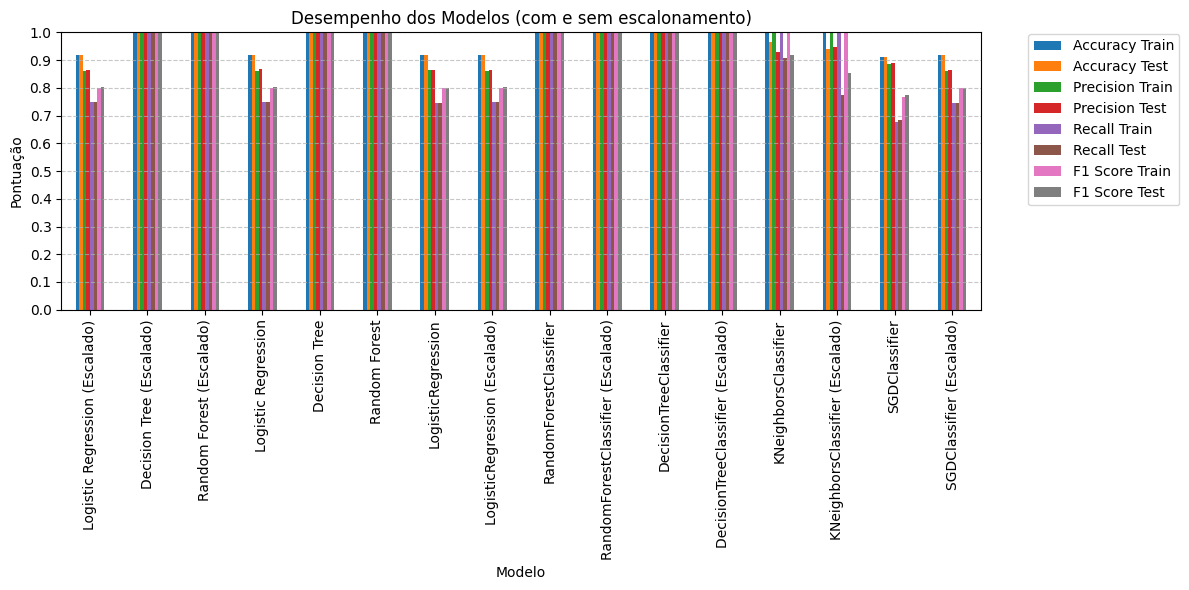

In [126]:
import matplotlib.ticker as ticker  # Importe para controlar as marcações do eixo

fig, ax = plt.subplots(figsize=(12, 6))
df_plot = df_resultados.set_index('Modelo')[[
    'Accuracy Train', 
    'Accuracy Test',
    'Precision Train',
    'Precision Test',
    'Recall Train', 
    'Recall Test',
    'F1 Score Train', 
    'F1 Score Test']]
df_plot.plot(kind='bar', ax=ax)

# Configurar marcações do eixo Y (passos de 0.1)
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))  # Define intervalos de 0.1
ax.set_ylim(0, 1)  # Garante que o eixo Y vá de 0 a 1 (ajuste se necessário)

# Adicionar grid
ax.grid(True, axis='y', linestyle='--', alpha=0.7)  # Grid horizontal tracejado

# Ajustar legenda fora do gráfico
ax.legend(
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0.1
)

plt.title('Desempenho dos Modelos (com e sem escalonamento)')
plt.ylabel('Pontuação')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
